In [1]:
import sys
import numpy as np
np.random.seed(0)

In [2]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.initializers import Constant
from keras.models import Model
from keras import backend as K

# Custom loss layer
class CustomMultiLossLayer(Layer):
    def __init__(self, nb_outputs=2, **kwargs):
        self.nb_outputs = nb_outputs
        self.is_placeholder = True
        super(CustomMultiLossLayer, self).__init__(**kwargs)
        
    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=Constant(0.), trainable=True)]
        super(CustomMultiLossLayer, self).build(input_shape)

    def multi_loss(self, ys_true, ys_pred):
        assert len(ys_true) == self.nb_outputs and len(ys_pred) == self.nb_outputs
        loss = 0
        for y_true, y_pred, log_var in zip(ys_true, ys_pred, self.log_vars):
            precision = K.exp(-log_var[0])
            loss += K.sum(precision * (y_true - y_pred)**2. + log_var[0], -1)
        return K.mean(loss)

    def call(self, inputs):
        ys_true = inputs[:self.nb_outputs]
        ys_pred = inputs[self.nb_outputs:]
        loss = self.multi_loss(ys_true, ys_pred)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return K.concatenate(inputs, -1)

Using TensorFlow backend.


In [3]:


N = 100
nb_epoch = 2000
batch_size = 20
nb_features = 1024
Q = 1
D1 = 1  # first output
D2 = 1  # second output



In [4]:
def gen_data(N):
    X = np.random.randn(N, Q)
    w1 = 2.
    b1 = 8.
    sigma1 = 1e1  # ground truth
    Y1 = X.dot(w1) + b1 + sigma1 * np.random.randn(N, D1)
    w2 = 3
    b2 = 3.
    sigma2 = 1e0  # ground truth
    Y2 = X.dot(w2) + b2 + sigma2 * np.random.randn(N, D2)
    return X, Y1, Y2


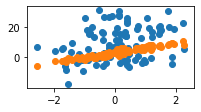

In [5]:
import pylab
%matplotlib inline

X, Y1, Y2 = gen_data(N)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y1[:, 0])
pylab.scatter(X[:, 0], Y2[:, 0])
pylab.show()


In [6]:
def get_prediction_model():
    inp = Input(shape=(Q,), name='inp')
    x = Dense(nb_features, activation='relu')(inp)
    y1_pred = Dense(D1)(x)
    y2_pred = Dense(D2)(x)
    return Model(inp, [y1_pred, y2_pred])

def get_trainable_model(prediction_model):
    inp = Input(shape=(Q,), name='inp')
    y1_pred, y2_pred = prediction_model(inp)
    y1_true = Input(shape=(D1,), name='y1_true')
    y2_true = Input(shape=(D2,), name='y2_true')
    out = CustomMultiLossLayer(nb_outputs=2)([y1_true, y2_true, y1_pred, y2_pred])
    return Model([inp, y1_true, y2_true], out)

prediction_model = get_prediction_model()
trainable_model = get_trainable_model(prediction_model)
trainable_model.compile(optimizer='adam', loss=None)
assert len(trainable_model.layers[-1].trainable_weights) == 2  # two log_vars, one for each output
assert len(trainable_model.losses) == 1

/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_multi_loss_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_multi_loss_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


In [7]:
hist = trainable_model.fit([X, Y1, Y2], nb_epoch=nb_epoch, batch_size=batch_size, verbose=0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


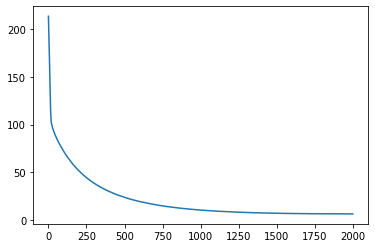

In [8]:


pylab.plot(hist.history['loss'])



In [9]:
# Found standard deviations (ground truth is 10 and 1):
[np.exp(K.get_value(log_var[0]))**0.5 for log_var in trainable_model.layers[-1].log_vars]

[8.649914126989751, 0.9247975978559427]

In [11]:
trainable_model.layers[-1].log_va